# Evaluation of ReInspect

Evaluation for end-to-end people detection in crowded scenes.

Let's start with importing the required files, seeding the random number generators and setting up the hyperparameters.

In [1]:
%load_ext autoreload
%autoreload 2
from utils.annolist import AnnotationLib as al

import matplotlib; matplotlib.use('Agg', warn=False)
import matplotlib.pyplot as plt
import random
import json
import cv2
from scipy.misc import imread
from train import *
from utils import load_data_mean, Rect, filter_rects
from IPython import display
%matplotlib inline

# Make sure that caffe is on the python path:
import apollocaffe
config = json.load(open("config.json", 'r'))
config["solver"]["start_iter"] = 250001

random.seed(config["solver"]["random_seed"])
apollocaffe.set_random_seed(config["solver"]["random_seed"])
apollocaffe.set_device(0)
apollocaffe.set_cpp_loglevel(3)

2015-08-21 13:16:17 - GPU device 0


Now lets load the data mean and the data.

In [2]:
data_mean = load_data_mean(config["data"]["idl_mean"], 
                           config["net"]["img_width"], 
                           config["net"]["img_height"], image_scaling=1.0)

test_gen = load_idl_list(config["data"]["test_idl"], data_mean, config["net"], False)

We can now load the snapshot weights.

In [3]:
net = apollocaffe.ApolloNet()
forward(net, test_gen.next(), config["net"], True)
# net.draw_to_file(config["logging"]["schematic_path"])
net.load("/deep/u/ysavani/snapshots/brainwash/clean_730000.h5")

We can now plot the schematic. Double click on the network schematic to zoom in.

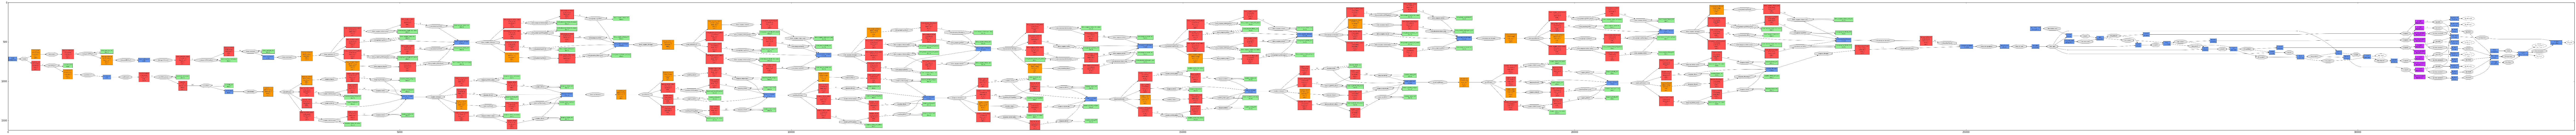

In [4]:
schematic = imread(config["logging"]["schematic_path"])
plt.figure(figsize=(200,200))
plt.imshow(schematic)

We can now begin to run the model and visualize the results.

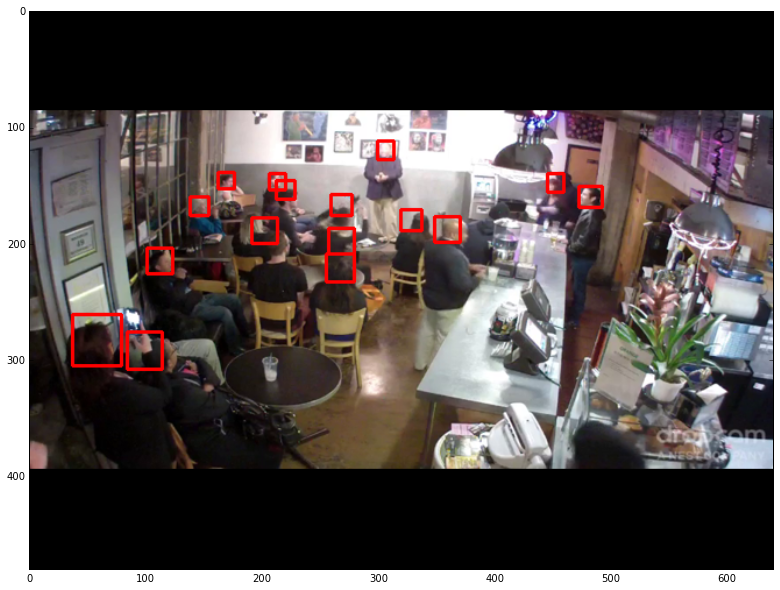

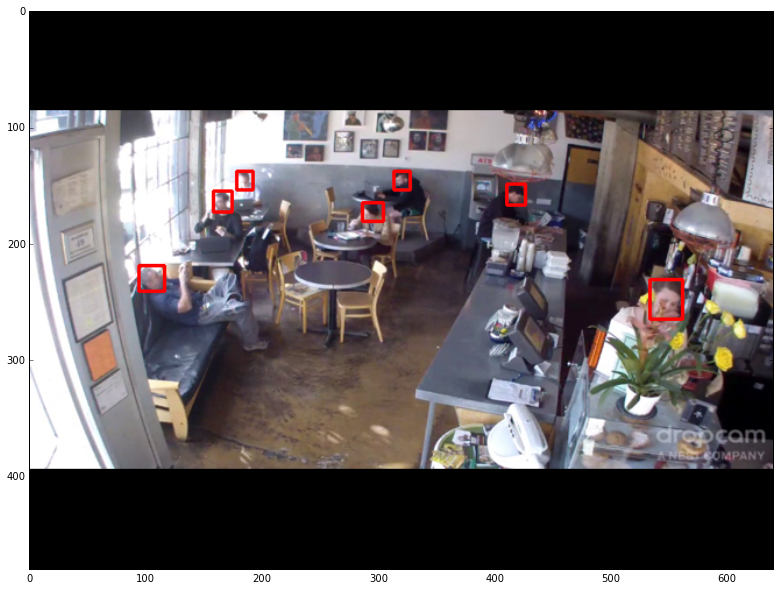

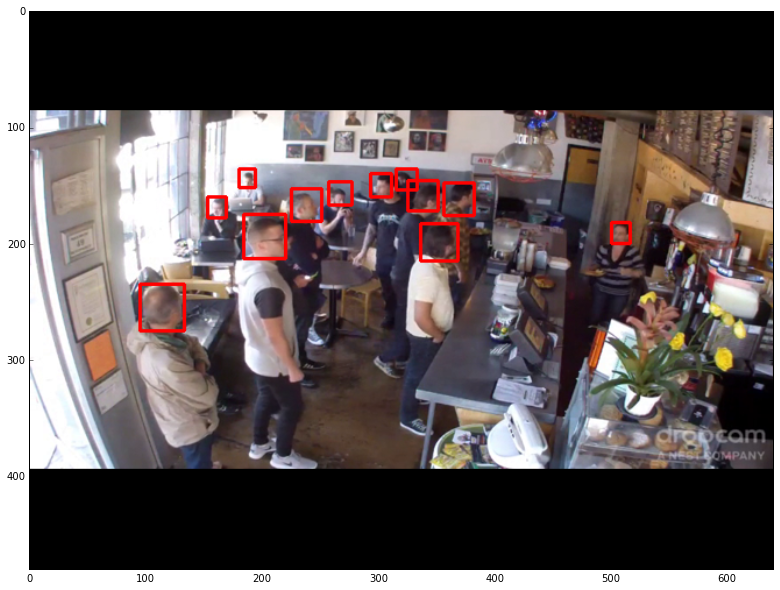

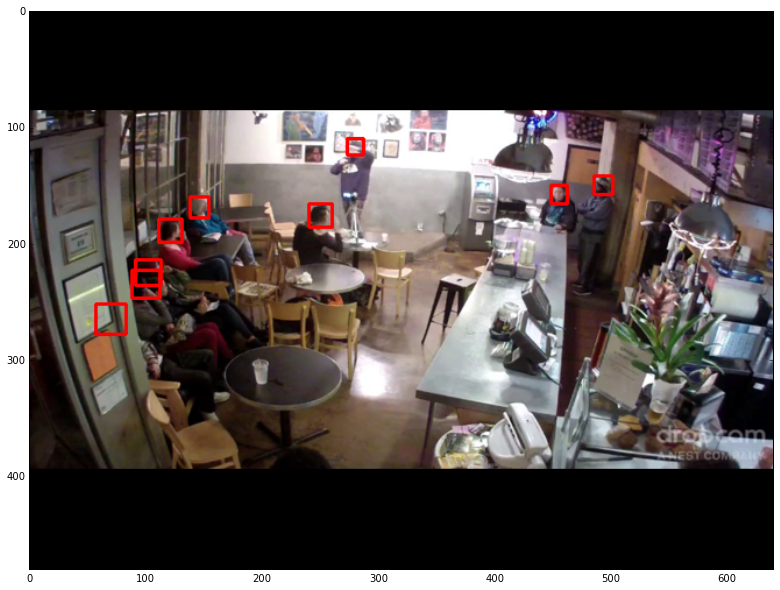

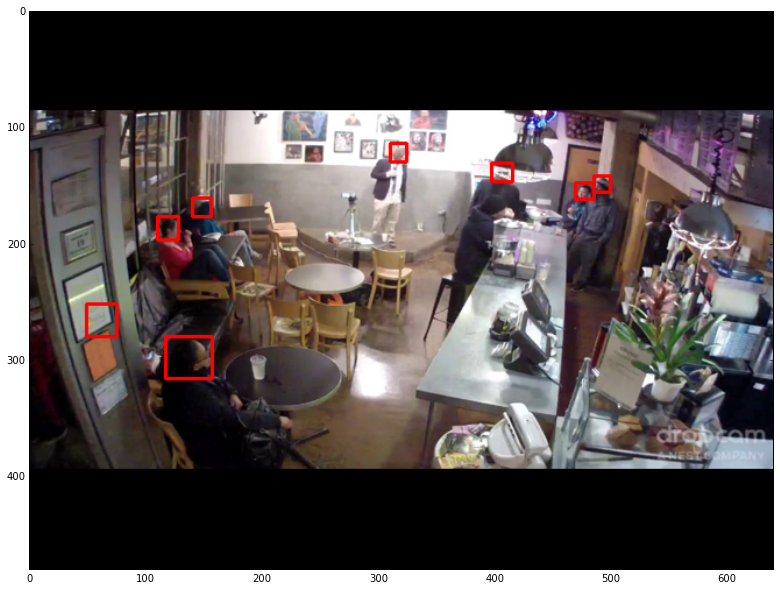

In [5]:
annolist = al.AnnoList()
net_config = config["net"]
pix_per_w = net_config["img_width"]/net_config["grid_width"]
pix_per_h = net_config["img_height"]/net_config["grid_height"]
for i in range(5):
    inputs = test_gen.next()
    bbox_list, conf_list = forward(net, inputs, net_config, True)
    
    img = inputs["raw"]
    png = inputs["imname"]
    all_rects = [[[] for x in range(net_config["grid_width"])] for y in range(net_config["grid_height"])]
    for n in range(len(bbox_list)):
        for k in range(net_config["grid_height"] * net_config["grid_width"]):
            y = int(k / net_config["grid_width"])
            x = int(k % net_config["grid_width"])
            bbox = bbox_list[n][k]
#             bbox = inputs["boxes"][0,k,:,n,0]
            conf = conf_list[n][k,1]
            abs_cx = pix_per_w/2 + pix_per_w*x + int(bbox[0,0,0])
            abs_cy = pix_per_h/2 + pix_per_h*y+int(bbox[1,0,0])
            w = bbox[2,0,0]
            h = bbox[3,0,0]
            if conf > 0.7:
                all_rects[y][x].append(Rect(abs_cx,abs_cy,w,h,conf - (0. * n)))
    
    acc_rects = []
    acc_rects = filter_rects(all_rects, .5, acc_rects, config=net_config)
    acc_rects = filter_rects(all_rects, .4, acc_rects, .6, config=net_config)
    acc_rects = filter_rects(all_rects, .3, acc_rects, .5, config=net_config)
    acc_rects = filter_rects(all_rects, .2, acc_rects, .4, config=net_config)
    acc_rects = filter_rects(all_rects, .1, acc_rects, .3, config=net_config)
    acc_rects = filter_rects(all_rects, .05, acc_rects, .2, config=net_config)

    accepted_rects = acc_rects
    
    display = True
    if display:
        for rect in acc_rects:
            assert rect.true_confidence <= rect.confidence
            if rect.true_confidence < 0.1:
                continue
            cv2.rectangle(img, (rect.cx-int(rect.width/2), rect.cy-int(rect.height/2)), 
                          (rect.cx+int(rect.width/2), rect.cy+int(rect.height/2)), 
                                              (255,0,0), 2)
     
        plt.figure(figsize=(15,10))
        plt.imshow(img)
        
    anno = al.Annotation()
    anno.imageName = inputs["imname"]
    for rect in accepted_rects:
        r = al.AnnoRect()
        scale = 1.07 if (rect.width < 50 and rect.height < 50) else 1.0
        r.x1 = rect.cx - rect.width/2.*scale
        r.x2 = rect.cx + rect.width/2.*scale
        r.y1 = rect.cy - rect.height/2.*scale
        r.y2 = rect.cy + rect.height/2.*scale
        r.score = rect.true_confidence
        anno.rects.append(r)
    annolist.append(anno)